In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
import numpy as np


In [2]:
X = pd.read_csv('../data/processed/footpath_for_ML.csv')
y = pd.read_csv('../data/processed/footpath_phase1.csv')
# y = y['duration_hours']
y = np.log1p(y['duration_hours'])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=42)

In [3]:
model = LGBMRegressor(n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8613
[LightGBM] [Info] Number of data points in the train set: 129698, number of used features: 223
[LightGBM] [Info] Start training from score 5.397917


In [4]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test)

# y_pred = model.predict(X_test)

In [5]:
from sklearn import metrics
import numpy as np

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1308.6288441592435
MSE: 8675175.872458316
RMSE: 2945.3651509546853


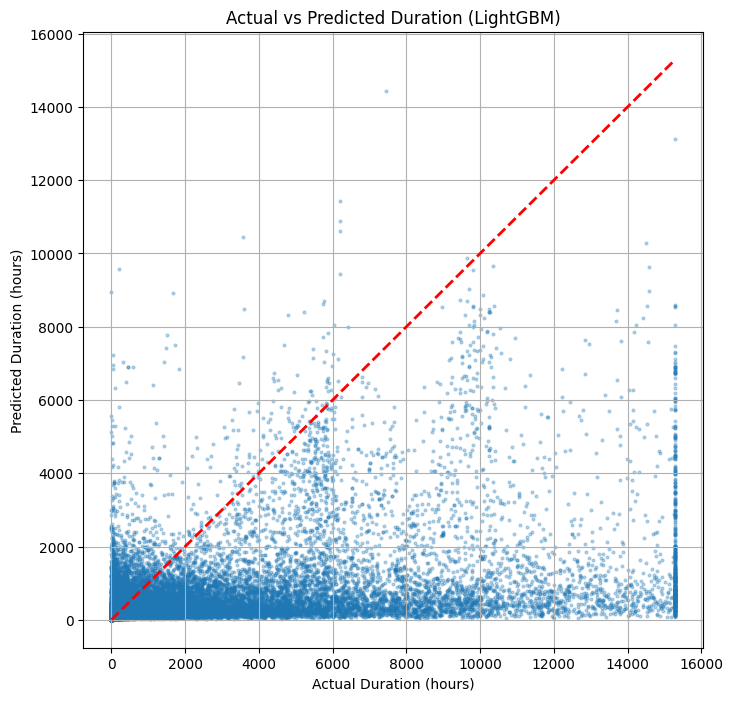

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.3, s=4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)

plt.xlabel("Actual Duration (hours)")
plt.ylabel("Predicted Duration (hours)")
plt.title("Actual vs Predicted Duration (LightGBM)")
plt.grid(True)
plt.show()


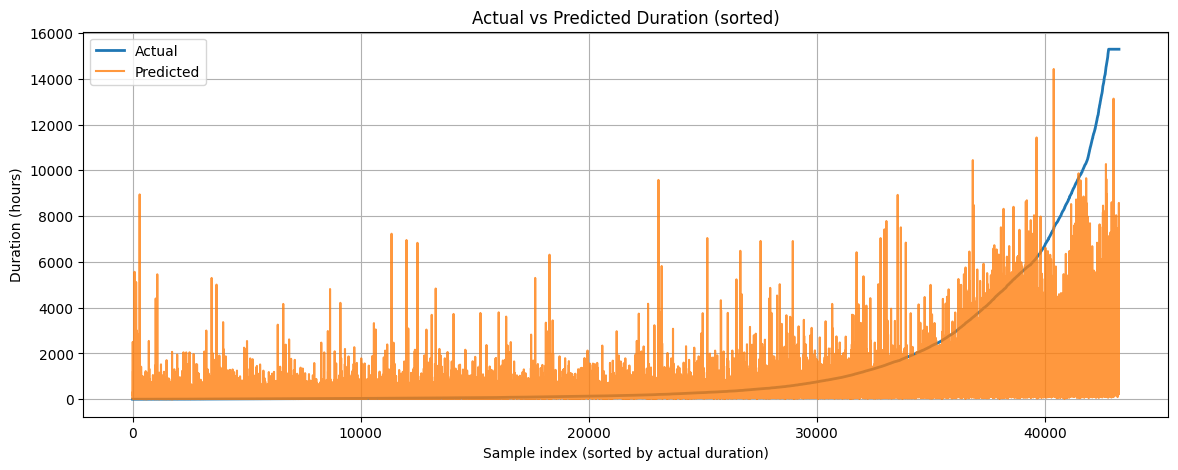

In [7]:
import numpy as np

# sort by actual duration
order = np.argsort(y_test.values)

plt.figure(figsize=(14,5))
plt.plot(y_test.values[order], label="Actual", linewidth=2)
plt.plot(y_pred[order], label="Predicted", alpha=0.8)
plt.legend()
plt.xlabel("Sample index (sorted by actual duration)")
plt.ylabel("Duration (hours)")
plt.title("Actual vs Predicted Duration (sorted)")
plt.grid(True)
plt.show()


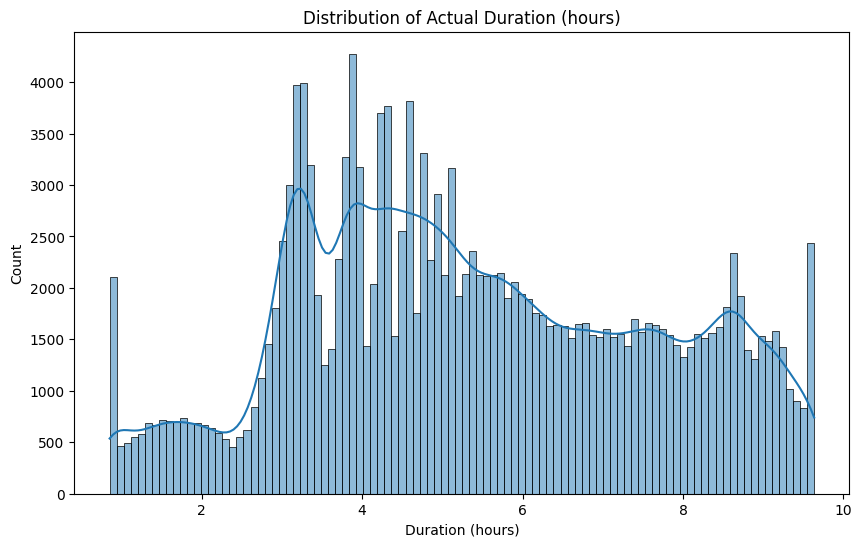

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(y, bins=100, kde=True)
plt.title("Distribution of Actual Duration (hours)")
plt.xlabel("Duration (hours)")
plt.ylabel("Count")
plt.show()


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# LightGBM stores feature importance inside model.feature_importances_
importances = model.feature_importances_

# match importance to column names
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# show top 30
feat_imp.head(30)


,feature,importance
60,lon,1600
61,lat,1533
1,month,1124
0,year,823
4,hour,800
2,day,733
38,tfidf__ถนน,441
3,weekday,391
54,tfidf__หลุม,335
35,tfidf__ชำรุด,265


C:\Users\Thossatham\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3606 (\N{THAI CHARACTER THO THUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Thossatham\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Thossatham\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3627 (\N{THAI CHARACTER HO HIP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Thossatham\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3621 (\N{THAI CHARACTER LO LING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Thossatham\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtool

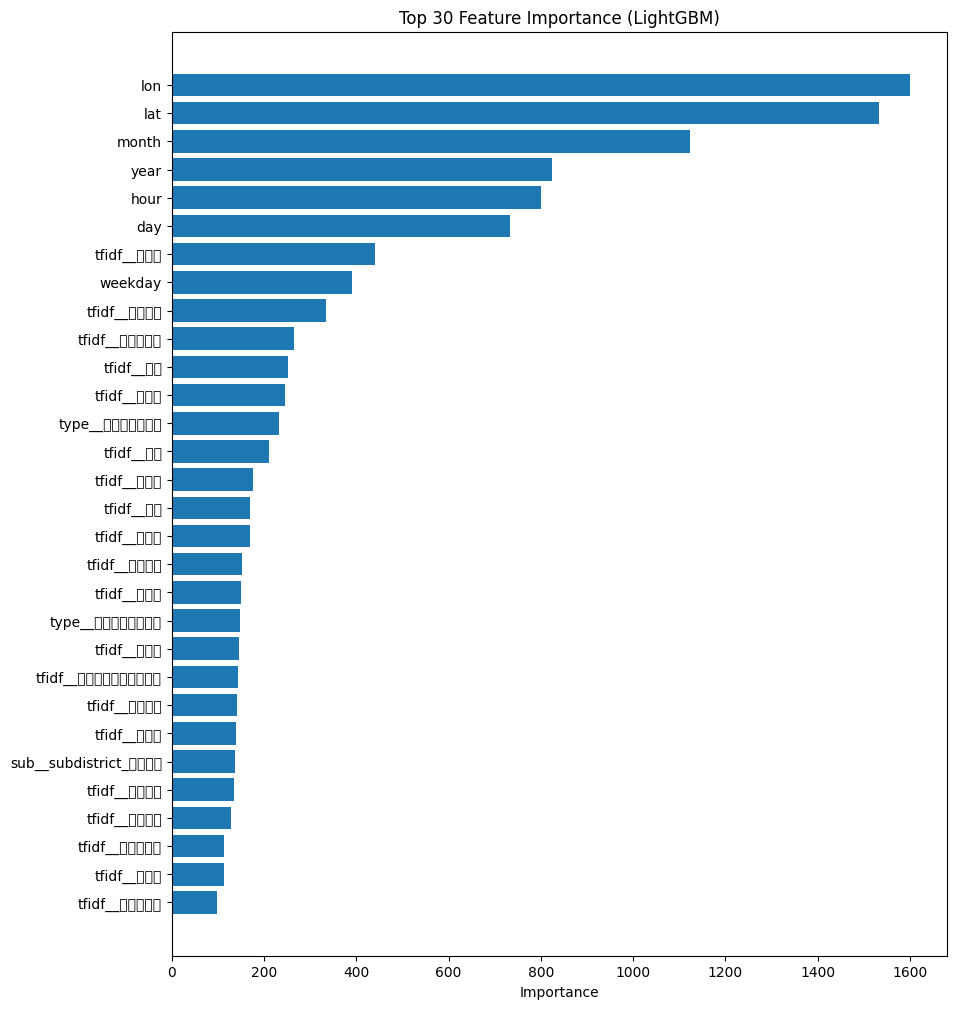

In [10]:
plt.figure(figsize=(10, 12))
plt.barh(feat_imp['feature'].head(30), feat_imp['importance'].head(30))
plt.gca().invert_yaxis()
plt.title("Top 30 Feature Importance (LightGBM)")
plt.xlabel("Importance")
plt.show()
